<a href="https://colab.research.google.com/github/binhluong84/Machine-Learning/blob/main/Pollen_image_clasification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Connect Google Drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
data = pd.read_csv('/gdrive/MyDrive/PollenDataset/pollen_data.csv', usecols=['filename', 'pollen_carrying'])

In [4]:
data

,filename,pollen_carrying
0,P10057-125r.jpg,1
1,P57380-120r.jpg,1
2,NP63671-221r.jpg,0
3,NP53776-47r.jpg,0
4,NP13382-201r.jpg,0
...,...,...
709,NP64239-233r.jpg,0
710,NP10304-132r.jpg,0
711,NP28671-238r.jpg,0
712,P14163-218r.jpg,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   filename         714 non-null    object
 1   pollen_carrying  714 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.3+ KB


In [6]:
def preprocess_df(df, image_path):
    df = df.copy()
    
    # Change filenames into filepaths
    df['filename'] = df['filename'].apply(lambda x: image_path / Path(x)).astype(str)
    
    # Create text labels for the images
    df['pollen_carrying'] = df['pollen_carrying'].replace({0: "NO POLLEN", 1: "POLLEN"})
    
    # Train-test split
    train_df, test_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=1)
    
    return train_df, test_df

In [8]:
train_df, test_df = preprocess_df(data, image_path='/gdrive/MyDrive/PollenDataset/images')

In [9]:
train_df

,filename,pollen_carrying
507,/gdrive/MyDrive/PollenDataset/images/P63102-20...,POLLEN
346,/gdrive/MyDrive/PollenDataset/images/NP1779-22...,NO POLLEN
160,/gdrive/MyDrive/PollenDataset/images/P27661-20...,POLLEN
463,/gdrive/MyDrive/PollenDataset/images/NP15065-2...,NO POLLEN
432,/gdrive/MyDrive/PollenDataset/images/P6113-76r...,POLLEN
...,...,...
144,/gdrive/MyDrive/PollenDataset/images/P58841-15...,POLLEN
645,/gdrive/MyDrive/PollenDataset/images/NP57593-1...,NO POLLEN
72,/gdrive/MyDrive/PollenDataset/images/P14225-22...,POLLEN
235,/gdrive/MyDrive/PollenDataset/images/NP19884-3...,NO POLLEN


In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='pollen_carrying',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='pollen_carrying',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='pollen_carrying',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 400 validated image filenames belonging to 2 classes.
Found 99 validated image filenames belonging to 2 classes.
Found 215 validated image filenames belonging to 2 classes.


In [12]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)


Epoch 1/100
13/13 [==============================] - 312s 23s/step - loss: 0.6928 - accuracy: 0.5075 - val_loss: 0.6961 - val_accuracy: 0.4545
Epoch 2/100
13/13 [==============================] - 2s 122ms/step - loss: 0.6913 - accuracy: 0.5275 - val_loss: 0.6986 - val_accuracy: 0.4545
Epoch 3/100
13/13 [==============================] - 2s 122ms/step - loss: 0.6909 - accuracy: 0.5275 - val_loss: 0.6988 - val_accuracy: 0.4545
Epoch 4/100
13/13 [==============================] - 2s 122ms/step - loss: 0.6910 - accuracy: 0.5275 - val_loss: 0.6982 - val_accuracy: 0.4545
Epoch 5/100
13/13 [==============================] - 2s 121ms/step - loss: 0.6913 - accuracy: 0.5275 - val_loss: 0.6937 - val_accuracy: 0.4545
Epoch 6/100
13/13 [==============================] - 2s 120ms/step - loss: 0.6926 - accuracy: 0.4875 - val_loss: 0.6894 - val_accuracy: 0.6768
Epoch 7/100
13/13 [==============================] - 2s 122ms/step - loss: 0.6880 - accuracy: 0.6925 - val_loss: 0.6920 - val_accuracy: 0.4545

Accuracy: 85.12%
7/7 [==============================] - 1s 86ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


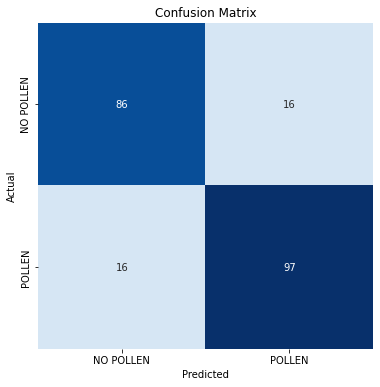

Classification Report:
----------------------
               precision    recall  f1-score   support

   NO POLLEN       0.84      0.84      0.84       102
      POLLEN       0.86      0.86      0.86       113

    accuracy                           0.85       215
   macro avg       0.85      0.85      0.85       215
weighted avg       0.85      0.85      0.85       215



In [13]:
results = model.evaluate(test_images, verbose=0)
print("Accuracy: {:.2f}%".format(results[1] * 100))

predictions = np.squeeze(model.predict(test_images) >= 0.5).astype(np.int)

cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=["NO POLLEN", "POLLEN"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["NO POLLEN", "POLLEN"])
plt.yticks(ticks=[0.5, 1.5], labels=["NO POLLEN", "POLLEN"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

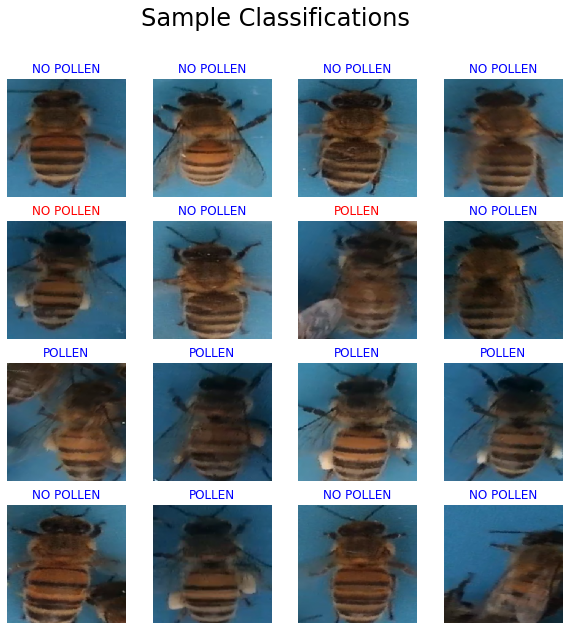

In [14]:
plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(test_images[0][0][i])
    plt.title(
        "NO POLLEN" if predictions[i] == 0 else "POLLEN",
        color='blue' if predictions[i] == test_images.labels[i] else 'red'
    )
    plt.axis('off')

plt.suptitle("Sample Classifications", size=24)
plt.show()